<a href="https://colab.research.google.com/github/enurta/memo/blob/master/GPR_NGB_ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install optuna
!pip install --upgrade git+https://github.com/stanfordmlgroup/ngboost.git
!pip install git+https://github.com/samoturk/mol2vec
!curl -Lo rdkit_installer.py https://git.io/fxiPZ
import rdkit_installer
%time rdkit_installer.install()
!pip install optuna

In [2]:
from scipy.stats import norm
import optuna
import matplotlib.figure as figure
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, RBF, ConstantKernel, Matern, DotProduct
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import fetch_california_housing
from ngboost import NGBRegressor
from ngboost.scores import MLE, CRPS
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import IPythonConsole
from mol2vec.features import mol2alt_sentence, mol2sentence, MolSentence, DfVec, sentences2vec
from gensim.models import word2vec
import sys, os

sys.path.append(os.path.dirname(os.path.dirname(os.getcwd()))+'/mol2vec')

In [3]:
# housing = fetch_california_housing()
# housing_data = pd.DataFrame(housing.data, columns=housing.feature_names)
# housing_target = pd.DataFrame(housing.target, columns=['housing_price'])

# X = np.array(housing_data)
# y = np.array(np.log(housing_target)).reshape(-1,)

In [17]:
df = pd.read_csv('/content/drive/My Drive/jacs.csv')
PandasTools.AddMoleculeColumnToFrame(df, smilesCol='SMILES')

model = word2vec.Word2Vec.load('/content/drive/My Drive/mol2vec_models/model_300dim.pkl')

df['sentence'] = df.apply(lambda x: MolSentence(mol2alt_sentence(x['ROMol'], 1)), axis=1)
df['mol2vec'] = [DfVec(x) for x in sentences2vec(df['sentence'], model, unseen='UNK')]

X = np.array([x.vec for x in df['mol2vec']])
y = np.array(df['measured log(solubility:mol/L)'])

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning:

This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function



In [18]:
X.shape

(1144, 300)

In [20]:
# x_train, x_drop, y_train, y_drop = train_test_split(X, y, train_size=10000, random_state=2, shuffle=True)
# x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.3, random_state=0, shuffle=True)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, shuffle=True)

print(x_train.shape)
print(x_test.shape)

(800, 300)
(344, 300)


In [10]:
kernels = [ConstantKernel() * DotProduct() + WhiteKernel(),
           ConstantKernel() * RBF() + WhiteKernel(),
           ConstantKernel() * RBF() + WhiteKernel() + ConstantKernel() * DotProduct(),
        #    ConstantKernel() * RBF(np.ones(x_train.shape[1])) + WhiteKernel(),
        #    ConstantKernel() * RBF(np.ones(x_train.shape[1])) + WhiteKernel() + ConstantKernel() * DotProduct(),
           ConstantKernel() * Matern(nu=1.5) + WhiteKernel(),
           ConstantKernel() * Matern(nu=1.5) + WhiteKernel() + ConstantKernel() * DotProduct(),
           ConstantKernel() * Matern(nu=0.5) + WhiteKernel(),
           ConstantKernel() * Matern(nu=0.5) + WhiteKernel() + ConstantKernel() * DotProduct(),
           ConstantKernel() * Matern(nu=2.5) + WhiteKernel(),
           ConstantKernel() * Matern(nu=2.5) + WhiteKernel() + ConstantKernel() * DotProduct()]

In [21]:
cv_model = GridSearchCV(
    Pipeline([
              ('std', StandardScaler()),
              ('gpr', GaussianProcessRegressor(alpha=0,normalize_y=True,random_state=0))
              ]),
               {'gpr__kernel': kernels}, cv=4, n_jobs=-1, verbose=3)
cv_model.fit(x_train, y_train)
print(cv_model.best_score_)
optimal_kernel = cv_model.best_params_['gpr__kernel']
gpr = Pipeline([
                    ('std', StandardScaler()),
                    ('gpr', GaussianProcessRegressor(optimal_kernel, alpha=0, normalize_y=True,random_state=0))
                    ])

gpr.fit(x_train, y_train)

#kernel=1**2 * Matern(length_scale=1, nu=0.5) + WhiteKernel(noise_level=1),

Fitting 4 folds for each of 9 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  1.4min finished


0.884669891120968


Pipeline(memory=None,
         steps=[('std',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('gpr',
                 GaussianProcessRegressor(alpha=0, copy_X_train=True,
                                          kernel=1**2 * Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1),
                                          n_restarts_optimizer=0,
                                          normalize_y=True,
                                          optimizer='fmin_l_bfgs_b',
                                          random_state=0))],
         verbose=False)

In [22]:
from sklearn.metrics import r2_score, mean_absolute_error
r2 = r2_score(y_train, gpr.predict(x_train))
print('Train R^2 :', r2)
print('Train MAE :', mean_absolute_error(y_train, gpr.predict(x_train)))
r2 = r2_score(y_test, gpr.predict(x_test))
print('Test R^2 :', r2)
print('Test MAE :', mean_absolute_error(y_test, gpr.predict(x_test)))

Train R^2 : 0.9881201572965651
Train MAE : 0.15894346668726328
Test R^2 : 0.8989006280520306
Test MAE : 0.4855249191325929


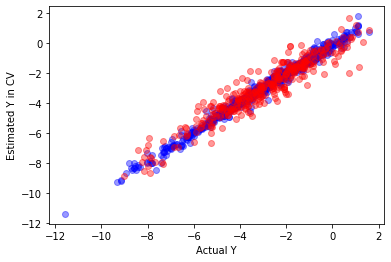

In [23]:
plt.scatter(y_train, gpr.predict(x_train), alpha = 0.4, c = 'blue')
plt.scatter(y_test, gpr.predict(x_test), alpha = 0.4, c = 'red')
#plt.plot([-2,2],[-2,2])
plt.xlabel('Actual Y')
plt.ylabel('Estimated Y in CV')
plt.show()

In [ ]:
def objective(trial):
    
    criterion = trial.suggest_categorical('criterion', ['mse', 'friedman_mse'])
    splitter = trial.suggest_categorical('splitter', ['best', 'random'])
    max_depth = trial.suggest_int('max_depth', 3, 7)
    min_s = trial.suggest_int('min_samples_leaf', 10, 35)
    gamma = trial.suggest_loguniform('gamma', 1e-8, 10)

    lr = trial.suggest_discrete_uniform('learning_rate', 0.01, 0.5, 0.01)
    subsample = trial.suggest_discrete_uniform('minibatch_frac', 0.6, 0.95, 0.05)
    col_sample = trial.suggest_discrete_uniform('col_sample', 0.05, 0.95, 0.05)
    score = trial.suggest_categorical('Score', [MLE, CRPS])

    #print(criterion, max_depth, lr, subsample, col_sample)

    base_tree = DecisionTreeRegressor(
        criterion=criterion,
        splitter=splitter,
        min_impurity_decrease=gamma,
        max_depth=max_depth,
        min_samples_leaf=min_s,
        random_state=0
        )
    
    model = NGBRegressor(
        Base=base_tree,
        Score=score,
        n_estimators=500,
        learning_rate=lr,
        minibatch_frac=subsample,
        col_sample=col_sample,
        random_state=0
    )
    
    score = cross_val_score(model, x_train, y_train, cv=4, scoring='r2', n_jobs=-1).mean()
    #print(score)

    return score

study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=1))
study.optimize(objective, n_trials=100)

In [ ]:
23 finished with value: 0.7893595290006727 and parameters: 
{'criterion': 'friedman_mse', 'splitter': 'random', 'max_depth': 6, 'min_samples_leaf': 20, 'gamma': 7.683410767261797e-06, 
'learning_rate': 0.11, 'minibatch_frac': 0.9, 'col_sample': 0.8500000000000001, 'Score': <class 'ngboost.scores.CRPScore'>}.

45 finished with value: 0.7897240003992678 and parameters: 
{'criterion': 'friedman_mse', 'splitter': 'random', 'max_depth': 7, 'min_samples_leaf': 21, 'gamma': 2.857667305819505e-05, 
'learning_rate': 0.11, 'minibatch_frac': 0.8, 'col_sample': 0.95, 'Score': <class 'ngboost.scores.CRPScore'>}.

164 finished with value: 0.7949146298681133 and parameters: 
{'criterion': 'mse', 'splitter': 'random', 'max_depth': 7, 'min_samples_leaf': 20, 'gamma': 1.022741616307504e-08,
'learning_rate': 0.060000000000000005, 'minibatch_frac': 0.85, 'col_sample': 0.9000000000000001, 'Score': <class 'ngboost.scores.CRPScore'>}. 

In [ ]:
21 finished with value: 0.836514790164192 and parameters: 
{'criterion': 'friedman_mse', 'splitter': 'random', 'max_depth': 5, 'min_samples_leaf': 32, 'gamma': 1.7828858069534001e-07, 
'learning_rate': 0.09, 'minibatch_frac': 0.6, 'col_sample': 0.6500000000000001, 'Score': <class 'ngboost.scores.LogScore'>}.

89 finished with value: 0.8380549310300426 and parameters: 
{'criterion': 'friedman_mse', 'splitter': 'random', 'max_depth': 7, 'min_samples_leaf': 32, 'gamma': 2.4499928693571205e-08, 
'learning_rate': 0.06999999999999999, 'minibatch_frac': 0.95, 'col_sample': 0.6000000000000001, 'Score': <class 'ngboost.scores.LogScore'>}.

In [25]:
base_tree = DecisionTreeRegressor(
    criterion='friedman_mse',
    splitter='random',
    max_depth=7,
    min_samples_leaf=32,
    min_impurity_decrease=2.4499928693571205e-08,
    random_state=0
    )

ngbr = NGBRegressor(
    Base=base_tree,
    Score=MLE,
    n_estimators=500,
    learning_rate=0.07,
    minibatch_frac=0.95,
    col_sample=0.6,
    random_state=0
)

#score = cross_val_score(model, x_train, y_train, cv=5, scoring='r2', n_jobs=-1).mean()
ngbr.fit(x_train, y_train)

[iter 0] loss=2.1615 val_loss=0.0000 scale=1.0000 norm=1.7934
[iter 100] loss=0.5504 val_loss=0.0000 scale=1.0000 norm=0.5955
[iter 200] loss=0.0520 val_loss=0.0000 scale=0.5000 norm=0.2362
[iter 300] loss=-0.1918 val_loss=0.0000 scale=0.5000 norm=0.2106
[iter 400] loss=-0.3734 val_loss=0.0000 scale=0.5000 norm=0.1942


NGBRegressor(Base=DecisionTreeRegressor(ccp_alpha=0.0, criterion='friedman_mse',
                                        max_depth=7, max_features=None,
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=2.4499928693571205e-08,
                                        min_impurity_split=None,
                                        min_samples_leaf=32,
                                        min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        presort='deprecated', random_state=0,
                                        splitter='random'),
             Dist=<class 'ngboost.distns.normal.Normal'>,
             Score=<class 'ngboost.scores.LogScore'>, col_sample=0.6,
             learning_rate=0.07, minibatch_frac=0.95, n_estimators=500,
             natural_gradient=True,
             random_state=RandomState(MT19937) at 0x7F64BB9E2990, tol

In [26]:
r2 = r2_score(y_train, ngbr.predict(x_train))
print('Train R^2 :', r2)
print('Train MAE :', mean_absolute_error(y_train, ngbr.predict(x_train)))
r2 = r2_score(y_test, ngbr.predict(x_test))
print('Test R^2 :', r2)
print('Test MAE :', mean_absolute_error(y_test, ngbr.predict(x_test)))

Train R^2 : 0.9885021865729282
Train MAE : 0.16633946973747485
Test R^2 : 0.8499869288981445
Test MAE : 0.613954009210392


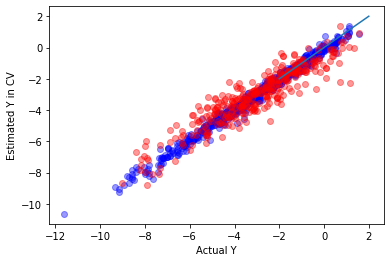

In [27]:
plt.scatter(y_train, ngbr.predict(x_train), alpha = 0.4, c = 'blue')
plt.scatter(y_test, ngbr.predict(x_test), alpha = 0.4, c = 'red')
plt.plot([-2,2],[-2,2])
plt.xlabel('Actual Y')
plt.ylabel('Estimated Y in CV')
plt.show()

In [28]:
def avg_predict(data):
    value = gpr.predict(data)+ngbr.predict(data)
    return value/2

r2 = r2_score(y_train, avg_predict(x_train))
print('Train R^2 :', r2)
print('Train MAE :', mean_absolute_error(y_train, avg_predict(x_train)))
r2 = r2_score(y_test, avg_predict(x_test))
print('Test R^2 :', r2)
print('Test MAE :', mean_absolute_error(y_test, avg_predict(x_test)))

Train R^2 : 0.9895128617137363
Train MAE : 0.15686334078963474
Test R^2 : 0.8853058779104918
Test MAE : 0.5305254347795864


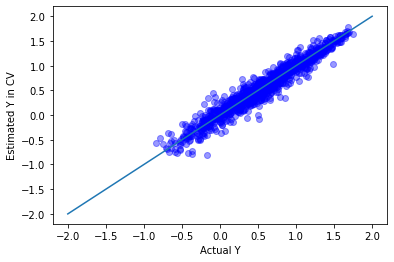

In [21]:
plt.scatter(ngbr.predict(x_test), gpr.predict(x_test), alpha = 0.4, c = 'blue')
plt.plot([-2,2],[-2,2])
plt.xlabel('Actual Y')
plt.ylabel('Estimated Y in CV')
plt.show()

In [25]:
pred_mu, pred_sigma = gpr.predict(x_test[2].reshape(1,-1), return_std=True)
print(pred_mu, pred_sigma)

[1.00093346] [0.31860825]


In [26]:
pred = ngbr.pred_dist(x_test[2].reshape(1,-1))
pred.params

{'loc': array([1.02929411]), 'scale': array([0.23208514])}

In [27]:
x_axis = np.arange(0,1,0.01)
ngy_axis = norm.pdf(x_axis,pred.params['loc'], pred.params['scale'])

gpy_axis = norm.pdf(x_axis,pred_mu,pred_sigma)

avy_axis = norm.pdf(x_axis,(pred_mu+pred.params['loc'])/2,(pred_sigma+pred.params['scale'])/2)

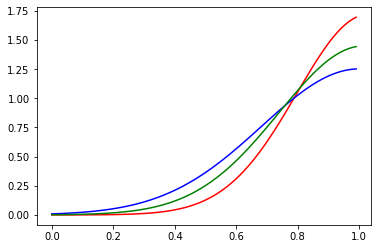

In [28]:
plt.plot(x_axis,ngy_axis,color='r')
plt.plot(x_axis,gpy_axis,color='b')
plt.plot(x_axis,avy_axis,color='g')
plt.show()